# Get Metrics for different Strata in Mamba

In [1]:
# Load Data
# Set working directory to '/n/groups/patel/shakson/aiready/'
import os
os.chdir("/home/shaksonisaac/CGM/mambatf/")

#LOAD Datasets
import pandas as pd
import io
from google.cloud import storage

_BUCKET_NAME = "cgmproject2025"

# Download dataset from GCS
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/train_finaltimeseries_meal.feather')
data_bytes = blob.download_as_bytes()
train = pd.read_feather(io.BytesIO(data_bytes))


# Download test set:
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/test_finaltimeseries_meal.feather')
data_bytes = blob.download_as_bytes()
test = pd.read_feather(io.BytesIO(data_bytes))

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)
    )

def quantile_loss(y_true, y_pred, q=0.5):
    return np.mean(np.maximum(q * (y_true - y_pred), (q - 1) * (y_true - y_pred)))

def calculate_metrics(t_grouped, train_df):
    static_vars = train_df[
        [
            "participant_id",
        ]
    ].drop_duplicates()
    t_grouped = t_grouped.merge(static_vars, on="participant_id", how="left")
    metrics_df = (
        t_grouped.groupby("participant_id")
        .apply(
            lambda df: pd.Series(
                {
                    "SMAPE": smape(df["target"], df["prediction"]),
                    "Quantile_Loss": quantile_loss(df["target"], df["prediction"]),
                    "MAE": np.mean(np.abs(df["prediction"] - df["target"])),
                    "RMSE": np.sqrt(np.mean(np.square(df["prediction"] - df["target"]))),
                }
            )
        )
        .reset_index()
    )
    return metrics_df

def get_confidence_intervals(df, metric, confidence=0.95):
    mean = df[metric].mean()
    sem = stats.sem(df[metric])  # Standard Error of the Mean
    margin_of_error = sem * stats.t.ppf((1 + confidence) / 2, len(df) - 1)
    return mean, mean - margin_of_error, mean + margin_of_error

def calculate_metrics_CI(records, train):
    """
    Calculate metrics for each participant in the records DataFrame.
    """
    metrics_df = calculate_metrics(records, train)

    confidence_intervals = {}
    for metric in ["SMAPE", "MAE", "RMSE", "Quantile_Loss"]:
        mean, lower, upper = get_confidence_intervals(metrics_df, metric)
        confidence_intervals[metric] = {
            "mean": mean,
            "lower": lower,
            "upper": upper
        }
    # Convert to DataFrame for better visualization
    confidence_df = pd.DataFrame(confidence_intervals).T.reset_index()
    confidence_df.columns = ["Metric", "Mean", "Lower CI", "Upper CI"]
    return confidence_df

In [3]:
# Load Mamba Model
# Load Data
import os
import sys

#from TFT_pytorch import log_memory, create_tft_dataloaders, TFT_train
from scripts.mamba2_576_mes import create_tft_dataloaders, TFT_train, save_tft_to_gcs, load_tft_from_gcs

param_48 = {
    "dataset": {"context_length": 576, "horizon": 12, "batch_size": 32},
    "mamba_tft_init": {"mamba_depth": 4, "mamba_dropout": 0.2},
    "mamba_block": {
        "d_model": 128,
        "dropout": 0.2,
        "return_hidden_attn": False,
        "d_state": 128, #160,   # ↑ pour 48h (avant 128). Monte si sous-mémoire
        "d_conv": 8, #12,
        "expand": 4,
        "headdim": 64,
        "ngroups": 1      # 👈 idem
    },
    "mamba2_mes_runtime": {
        "mes_diag": True,
        "x_share_mode": "mean",
        "chunk_size": 128, #512,
        "dt_limit": (1e-3, 10.0),
        "learnable_init_states": True,
        "D": None
    },
    "checkpoint": {True}
}

training, val_dataloader, train_dataloader, validation = create_tft_dataloaders(train, horizon=12, context_length=576, batchsize=32)

tft = load_tft_from_gcs(model_name="Mamba2_12h_576c_MES", training_dataset=training)
tft.eval()  # Put model in evaluation mode

/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[GPU] NVIDIA A100-SXM4-40GB  CC=(8, 0), BF16=OK
[2025-08-25 04:41:58.338761] 🚀 Start of Dataloader Creation
GPU Mem allocated: 0.00 GB | reserved: 0.00 GB


/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Loaded TFT from gs://cgmproject2025/models/predictions/Mamba2_12h_576c_MES/


MambaTFT(
  	"attention_head_size":               8
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'ds', 'target': 'cgm_glucose', 'group_ids': ['participant_id'], 'weight': None, 'max_encoder_length': 576, 'min_encoder_length': 576, 'min_prediction_idx': np.int64(11), 'min_prediction_length': 12, 'max_prediction_length': 12, 'static_categoricals': ['participant_id', 'clinical_site', 'study_group'], 'static_reals': ['age'], 'time_varying_known_categoricals': ['sleep_stage'], 'time_varying_known_reals': ['ds', 'minute_of_day', 'tod_sin', 'tod_cos', 'activity_steps', 'calories_value', 'heartrate', 'oxygen_saturation', 'respiration_rate', 'stress_level', 'predmeal_flag'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['cgm_glucose', 'cgm_lag_1', 'cgm_lag_3', 'cgm_lag_6', 'cgm_diff_lag_1', 'cgm_diff_lag_3', 'cgm_diff_lag_6', 'cgm_lagdiff_1_3', 'cgm_lagdiff_3_6', 'cgm_roll

In [ ]:
# # Get global metrics:
# raw_preds = tft.predict(val_dataloader, mode="raw", return_x=True, return_index=True)
# print("Shape of raw_preds:", raw_preds.output["prediction"].shape)
# y_pred = raw_preds.output["prediction"][:, :, 1] #To get median quantile.
# y_true = raw_preds.x["decoder_target"]
# index_df = raw_preds.index
# records = []
# for i in range(len(index_df)):
#     uid = index_df.iloc[i]["participant_id"]
#     time_start = index_df.iloc[i]["ds"]
#     for t in range(y_pred.shape[1]):
#         records.append({
#             "participant_id": uid,
#             "ds": int(time_start + t),
#             "target": float(y_true[i, t]),
#             "prediction": float(y_pred[i, t]),
#         })
# records = pd.DataFrame(records)

# metricsCI = calculate_metrics_CI(records, train)
# print(metricsCI)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# -------------------------------------------------------------------
def create_prediction_df_quantile(tft, val_dataloader):
    """
    Returns a DataFrame with columns:
      participant_id, ds (time index),
      target (true cgm_glucose),
      prediction (median), q_0.05, q_0.95
    """
    df = tft.predict(
        val_dataloader,
        mode="quantiles",    # get all quantiles specified during training
        return_index=True,     # include participant_id & ds
        return_x=False         # no need for raw x
    )
    # Rename median column for consistency
    df = df.rename(columns={"q_0.5": "prediction"})
    # select only the columns we need
    return df[["participant_id", "ds", "target", "prediction", "q_0.05", "q_0.95"]]

# -------------------------------------------------------------------
def smape(y_true, y_pred):
    """Symmetric mean absolute percentage error"""
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)
    )

# -------------------------------------------------------------------
def quantile_loss(y_true, y_pred, q=0.5):
    """Pinball loss for single quantile q"""
    delta = y_true - y_pred
    return np.mean(np.maximum(q * delta, (q - 1) * delta))

# -------------------------------------------------------------------
def MAE_normalized(y_true, y_pred):
    """MAE normalized by sum of true values"""
    total = np.abs(y_true).sum()
    if total == 0:
        return 0.0
    return np.mean(np.abs(y_pred - y_true)) / (total + 1e-8)

# -------------------------------------------------------------------
def calculate_metrics(predictions_df, train_df):
    """
    Compute per-participant metrics and merge in static covariates.
    Expects:
      predictions_df with ['participant_id','target','prediction']
      train_df containing at least ['participant_id','clinical_site','study_group','age']
    """
    static_vars = (
        train_df
        [["participant_id", "clinical_site", "study_group", "age"]]
        .drop_duplicates()
    )
    df = predictions_df.merge(static_vars, on="participant_id", how="left")

    metrics_df = (
        df.groupby("participant_id")
          .apply(lambda g: pd.Series({
                "R2":            r2_score(g["target"], g["prediction"]),
                "SMAPE":         smape(g["target"], g["prediction"]),
                "Quantile_Loss": quantile_loss(g["target"], g["prediction"]),
                "MAE_norm":      MAE_normalized(g["target"], g["prediction"]),
                "MAE":           np.mean(np.abs(g["prediction"] - g["target"])),
                # static covariates:
                "clinical_site": g["clinical_site"].iloc[0],
                "study_group":   g["study_group"].iloc[0],
                "age":           g["age"].iloc[0],
          }))
          .reset_index()
    )
    return metrics_df

# -------------------------------------------------------------------
def filter_and_average_metrics(
    metrics_df,
    printed=True,
    participant_id=None,
    clinical_site=None,
    study_group=None,
    age_min=None,
    age_max=None
):
    """
    Filters metrics_df according to provided criteria and returns average metrics.

    Returns:
      avg_metrics: dict
      filtered_df: pd.DataFrame
    """
    df = metrics_df.copy()
    if participant_id:
        df = df[df.participant_id == participant_id]
    if clinical_site:
        df = df[df.clinical_site == clinical_site]
    if study_group:
        df = df[df.study_group == study_group]
    if age_min is not None:
        df = df[df.age >= age_min]
    if age_max is not None:
        df = df[df.age <= age_max]

    avg_metrics = {
        "R2":            df.R2.mean(),
        "SMAPE":         df.SMAPE.mean(),
        "Quantile_Loss": df.Quantile_Loss.mean(),
        "MAE_norm":      df.MAE_norm.mean(),
    }

    if printed:
        print("Average Metrics:")
        for k, v in avg_metrics.items():
            print(f"{k}: {v:.4f}")

    return avg_metrics, df

# -------------------------------------------------------------------
def plot_metric_per_category(
    model_results,
    metric: str,
    by: str = "study_group",
    show_error: bool = True
):
    """
    Plots a chosen metric by a categorical variable plus a global summary.

    model_results: pd.DataFrame or dict[str, pd.DataFrame]
    metric: one of ['R2','SMAPE','Quantile_Loss','MAE_norm','MAE']
    by: categorical column in metrics_df
    show_error: include std dev as error bars
    """
    if isinstance(model_results, pd.DataFrame):
        model_results = {"Model": model_results}

    # gather categories
    categories = sorted({
        cat for df in model_results.values() if by in df.columns
        for cat in df[by].dropna().unique()
    })
    rows = []
    for name, df in model_results.items():
        if by not in df.columns:
            raise ValueError(f"Column '{by}' not in {name}")
        means = df.groupby(by)[metric].mean()
        stds  = df.groupby(by)[metric].std()
        for cat in categories:
            if cat in means:
                rows.append({"Category": cat,
                             "Metric": means[cat],
                             "Error":  stds[cat] if show_error else 0,
                             "Model": name})
        # global point
        rows.append({"Category": "__GLOBAL__",
                     "Metric": df[metric].mean(),
                     "Error":  df[metric].std() if show_error else 0,
                     "Model": name})

    plot_df = pd.DataFrame(rows)
    order = ["__GLOBAL__"] + categories
    plot_df["Category"] = pd.Categorical(plot_df["Category"],
                                           categories[::-1], ordered=True)

    fig, ax = plt.subplots(figsize=(10, max(6, len(order)*0.3)))
    for name in plot_df.Model.unique():
        sub = plot_df[plot_df.Model == name]
        if show_error:
            ax.errorbar(sub.Metric, sub.Category,
                        xerr=sub.Error, fmt='o', label=name, capsize=4)
        else:
            ax.scatter(sub.Metric, sub.Category, label=name)

    ax.set_yticks(range(len(order)))
    ax.set_yticklabels(order[::-1])
    ax.set_xlabel(metric)
    ax.set_title(f"{metric} by {by} (+ global)")
    ax.legend(title="Model", loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# -------------------------------------------------------------------
def create_prediction_df_quantile(tft, val_dataloader):
    """
    Returns a DataFrame with columns:
      participant_id, ds (time index),
      target (true cgm_glucose),
      prediction (median), q_0.05, q_0.95
    """
    df = tft.predict(
        val_dataloader,
        mode="quantiles",    # get all quantiles specified during training
        return_index=True,     # include participant_id & ds
        return_x=False         # no need for raw x
    )
    df = df.rename(columns={"q_0.5": "prediction"})
    return df[["participant_id", "ds", "target", "prediction", "q_0.05", "q_0.95"]]

# -------------------------------------------------------------------
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)
    )

# -------------------------------------------------------------------
def quantile_loss(y_true, y_pred, q=0.5):
    delta = y_true - y_pred
    return np.mean(np.maximum(q * delta, (q - 1) * delta))

# -------------------------------------------------------------------
def MAE_normalized(y_true, y_pred):
    total = np.abs(y_true).sum()
    if total == 0:
        return 0.0
    return np.mean(np.abs(y_pred - y_true)) / (total + 1e-8)

# -------------------------------------------------------------------
def calculate_metrics(predictions_df, train_df):
    static_vars = (
        train_df
        [["participant_id", "clinical_site", "study_group", "age"]]
        .drop_duplicates()
    )
    df = predictions_df.merge(static_vars, on="participant_id", how="left")

    metrics_df = (
        df.groupby("participant_id")
          .apply(lambda g: pd.Series({
                "R2":            r2_score(g["target"], g["prediction"]),
                "SMAPE":         smape(g["target"], g["prediction"]),
                "Quantile_Loss": quantile_loss(g["target"], g["prediction"]),
                "MAE_norm":      MAE_normalized(g["target"], g["prediction"]),
                "MAE":           np.mean(np.abs(g["prediction"] - g["target"])),
                "clinical_site": g["clinical_site"].iloc[0],
                "study_group":   g["study_group"].iloc[0],
                "age":           g["age"].iloc[0],
          }))
          .reset_index()
    )
    return metrics_df

# -------------------------------------------------------------------
def filter_and_average_metrics(
    metrics_df,
    printed=True,
    participant_id=None,
    clinical_site=None,
    study_group=None,
    age_min=None,
    age_max=None
):
    df = metrics_df.copy()
    if participant_id:
        df = df[df.participant_id == participant_id]
    if clinical_site:
        df = df[df.clinical_site == clinical_site]
    if study_group:
        df = df[df.study_group == study_group]
    if age_min is not None:
        df = df[df.age >= age_min]
    if age_max is not None:
        df = df[df.age <= age_max]

    avg_metrics = {
        "R2":            df.R2.mean(),
        "SMAPE":         df.SMAPE.mean(),
        "Quantile_Loss": df.Quantile_Loss.mean(),
        "MAE_norm":      df.MAE_norm.mean(),
    }
    if printed:
        print("Average Metrics:")
        for k, v in avg_metrics.items():
            print(f"{k}: {v:.4f}")
    return avg_metrics, df

# -------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap
from sklearn.metrics import r2_score

# -------------------------------------------------------------------
def create_prediction_df_quantile(tft, val_dataloader):
    """
    Returns a DataFrame with columns:
      participant_id, ds (time index),
      target (true cgm_glucose),
      prediction (median), q_0.05, q_0.95
    """
    df = tft.predict(
        val_dataloader,
        mode="quantiles",    # get all quantiles specified during training
        return_index=True,     # include participant_id & ds
        return_x=False         # no need for raw x
    )
    df = df.rename(columns={"q_0.5": "prediction"})
    return df[["participant_id", "ds", "target", "prediction", "q_0.05", "q_0.95"]]

# -------------------------------------------------------------------
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)
    )

# -------------------------------------------------------------------
def quantile_loss(y_true, y_pred, q=0.5):
    delta = y_true - y_pred
    return np.mean(np.maximum(q * delta, (q - 1) * delta))

# -------------------------------------------------------------------
def MAE_normalized(y_true, y_pred):
    total = np.abs(y_true).sum()
    if total == 0:
        return 0.0
    return np.mean(np.abs(y_pred - y_true)) / (total + 1e-8)

# -------------------------------------------------------------------
def calculate_metrics(predictions_df, train_df):
    static_vars = (
        train_df
        [["participant_id", "clinical_site", "study_group", "age"]]
        .drop_duplicates()
    )
    df = predictions_df.merge(static_vars, on="participant_id", how="left")

    metrics_df = (
        df.groupby("participant_id")
          .apply(lambda g: pd.Series({
                "R2":            r2_score(g["target"], g["prediction"]),
                "SMAPE":         smape(g["target"], g["prediction"]),
                "Quantile_Loss": quantile_loss(g["target"], g["prediction"]),
                "MAE_norm":      MAE_normalized(g["target"], g["prediction"]),
                "MAE":           np.mean(np.abs(g["prediction"] - g["target"])),
                "RMSE": np.sqrt(np.mean(np.square(g["prediction"] - g["target"]))),
                "clinical_site": g["clinical_site"].iloc[0],
                "study_group":   g["study_group"].iloc[0],
                "age":           g["age"].iloc[0],
          }))
          .reset_index()
    )
    return metrics_df

# -------------------------------------------------------------------
def filter_and_average_metrics(
    metrics_df,
    printed=True,
    participant_id=None,
    clinical_site=None,
    study_group=None,
    age_min=None,
    age_max=None
):
    df = metrics_df.copy()
    if participant_id:
        df = df[df.participant_id == participant_id]
    if clinical_site:
        df = df[df.clinical_site == clinical_site]
    if study_group:
        df = df[df.study_group == study_group]
    if age_min is not None:
        df = df[df.age >= age_min]
    if age_max is not None:
        df = df[df.age <= age_max]

    avg_metrics = {
        "R2":            df.R2.mean(),
        "SMAPE":         df.SMAPE.mean(),
        "Quantile_Loss": df.Quantile_Loss.mean(),
        "MAE_norm":      df.MAE_norm.mean(),
        "RMSE":          df.RMSE.mean(),
    }
    if printed:
        print("Average Metrics:")
        for k, v in avg_metrics.items():
            print(f"{k}: {v:.4f}")
    return avg_metrics, df

# -------------------------------------------------------------------
def plot_metric_per_category(
    model_results,
    metric: str,
    by: str = "study_group",
    show_error: bool = True,
    wrap_width: int = 20
):
    """
    Plots a metric by a categorical variable and includes a global summary.
    Long category labels are wrapped at 'wrap_width' characters.
    """
    if isinstance(model_results, pd.DataFrame):
        model_results = {"Model": model_results}

    # gather categories
    categories = sorted({
        cat for df in model_results.values() if by in df.columns
        for cat in df[by].dropna().unique()
    })
    order = ["__GLOBAL__"] + categories

    # build data rows
    rows = []
    for name, df in model_results.items():
        means = df.groupby(by)[metric].mean()
        stds  = df.groupby(by)[metric].std()
        for cat in order:
            if cat == "__GLOBAL__":
                val = df[metric].mean(); err = df[metric].std() if show_error else 0
            else:
                val = means.get(cat, np.nan); err = stds.get(cat, 0) if show_error else 0
            rows.append({"Category": cat, "Metric": val, "Error": err, "Model": name})

    plot_df = pd.DataFrame(rows)
    # map categories to numeric positions
    y_map = {c: i for i, c in enumerate(order[::-1])}
    plot_df["y_pos"] = plot_df["Category"].map(y_map)

    fig, ax = plt.subplots(figsize=(10, max(6, len(order)*0.3)))
    for name in plot_df.Model.unique():
        sub = plot_df[plot_df.Model == name]
        if show_error:
            ax.errorbar(sub.Metric, sub.y_pos,
                        xerr=sub.Error, fmt='o', label=name, capsize=4)
        else:
            ax.scatter(sub.Metric, sub.y_pos, label=name)

    # wrap category labels
    wrapped = ["\n".join(textwrap.wrap(label, wrap_width)) for label in order[::-1]]
    ax.set_yticks(list(y_map.values()))
    ax.set_yticklabels(wrapped)

    ax.set_xlabel(metric)
    ax.set_title(f"{metric} by {by} (+ global)")
    ax.legend(title="Model", loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [6]:
# Get global metrics:
raw_preds = tft.predict(val_dataloader, mode="raw", return_x=True, return_index=True)
print("Shape of raw_preds:", raw_preds.output["prediction"].shape)
y_pred = raw_preds.output["prediction"][:, :, 1] #To get median quantile.
y_true = raw_preds.x["decoder_target"]
index_df = raw_preds.index
records = []
for i in range(len(index_df)):
    uid = index_df.iloc[i]["participant_id"]
    time_start = index_df.iloc[i]["ds"]
    for t in range(y_pred.shape[1]):
        records.append({
            "participant_id": uid,
            "ds": int(time_start + t),
            "target": float(y_true[i, t]),
            "prediction": float(y_pred[i, t]),
        })
records = pd.DataFrame(records)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Shape of raw_preds: torch.Size([741, 12, 3])


In [45]:
metrics_df = calculate_metrics(records, train_df=train)

/tmp/ipykernel_36412/3255693165.py:154: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [46]:
metrics_df

,participant_id,R2,SMAPE,Quantile_Loss,MAE_norm,MAE,RMSE,clinical_site,study_group,age
0,1023,-2.490117,6.965534,5.210639,0.005667,10.421277,13.794351,UW,insulin_dependent,67
1,1024,-0.711146,3.342854,1.772941,0.002779,3.545882,5.131533,UW,pre_diabetes_lifestyle_controlled,63
2,1026,0.841003,2.771115,2.080342,0.002340,4.160684,4.623926,UW,pre_diabetes_lifestyle_controlled,66
3,1027,-0.403296,2.476235,3.393430,0.002049,6.786860,8.670845,UW,oral_medication_and_or_non_insulin_injectable_...,53
4,1028,0.260638,4.108726,2.220655,0.003422,4.441310,4.999453,UW,oral_medication_and_or_non_insulin_injectable_...,64
...,...,...,...,...,...,...,...,...,...,...
736,7405,-1.856207,2.894396,2.384993,0.002396,4.769986,6.188775,UAB,oral_medication_and_or_non_insulin_injectable_...,87
737,7406,-0.650781,6.036456,6.327633,0.004854,12.655266,14.929493,UAB,oral_medication_and_or_non_insulin_injectable_...,44
738,7407,0.769833,9.360766,5.421835,0.008050,10.843670,12.792727,UAB,oral_medication_and_or_non_insulin_injectable_...,66
739,7409,-0.214330,2.840585,1.990377,0.002354,3.980755,4.957998,UAB,insulin_dependent,44


In [25]:
metrics_df['MAE'].mean()

np.float64(5.611713735037326)

In [35]:
# -------------------------------------------------------------------
def plot_metric_per_category(
    model_results,
    metric: str,
    by: str = "study_group",
    show_error: bool = True,
    wrap_width: int = 20
):
    """
    Plots a metric by a categorical variable and includes a global summary.
    Long category labels are wrapped at 'wrap_width' characters.
    """
    if isinstance(model_results, pd.DataFrame):
        model_results = {"Model": model_results}

    # gather categories
    categories = sorted({
        cat for df in model_results.values() if by in df.columns
        for cat in df[by].dropna().unique()
    })
    order = ["__GLOBAL__"] + categories

    # build data rows
    rows = []
    for name, df in model_results.items():
        means = df.groupby(by)[metric].mean()
        stds  = df.groupby(by)[metric].std()
        for cat in order:
            if cat == "__GLOBAL__":
                val = df[metric].mean(); err = df[metric].std() if show_error else 0
            else:
                val = means.get(cat, np.nan); err = stds.get(cat, 0) if show_error else 0
            rows.append({"Category": cat, "Metric": val, "Error": err, "Model": name})

    plot_df = pd.DataFrame(rows)
    # map categories to numeric positions
    y_map = {c: i for i, c in enumerate(order[::-1])}
    plot_df["y_pos"] = plot_df["Category"].map(y_map)

    fig, ax = plt.subplots(figsize=(10, max(6, len(order)*0.3)))
    for name in plot_df.Model.unique():
        sub = plot_df[plot_df.Model == name]
        if show_error:
            ax.errorbar(sub.Metric, sub.y_pos,
                        xerr=sub.Error, fmt='o', label=name, capsize=4)
        else:
            ax.scatter(sub.Metric, sub.y_pos, label=name)

    # wrap category labels
    wrapped = ["\n".join(textwrap.wrap(label, wrap_width)) for label in order[::-1]]
    ax.set_yticks(list(y_map.values()))
    ax.set_yticklabels(wrapped)

    ax.set_xlabel(metric)
    ax.set_title(f"{metric} by {by} (+ global)")
    ax.legend(title="Model", loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [36]:
import numpy as np
import pandas as pd
import textwrap
import matplotlib.pyplot as plt

# Optional but recommended for small n CIs
try:
    from scipy.stats import t
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

def _t_ci(x, ci=0.95):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    n = x.size
    if n == 0:
        return np.nan, np.nan, np.nan
    mean = x.mean()
    if n == 1:
        return mean, np.nan, np.nan
    sd = x.std(ddof=1)
    sem = sd / np.sqrt(n)
    alpha = 1 - ci
    if _HAS_SCIPY and n > 1:
        crit = t.ppf(1 - alpha/2, df=n-1)
    else:
        # normal approx fallback
        crit = 1.96 if np.isclose(ci, 0.95) else np.sqrt(2) * erfcinv(alpha) * 2  # crude
    lo = mean - crit * sem
    hi = mean + crit * sem
    return mean, lo, hi

def _bootstrap_ci(x, ci=0.95, n_boot=2000, rng=None):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    n = x.size
    if n == 0:
        return np.nan, np.nan, np.nan
    if rng is None:
        rng = np.random.default_rng()
    boots = []
    for _ in range(n_boot):
        sample = rng.choice(x, size=n, replace=True)
        boots.append(sample.mean())
    boots = np.sort(np.array(boots))
    mean = x.mean()
    alpha = 1 - ci
    lo = np.quantile(boots, alpha/2)
    hi = np.quantile(boots, 1 - alpha/2)
    return mean, lo, hi

# -------------------------------------------------------------------
def plot_metric_per_category(
    model_results,
    metric: str,
    by: str = "study_group",
    ci: float = 0.95,
    ci_method: str = "t",           # "t" or "bootstrap"
    n_boot: int = 2000,
    random_state: int | None = 42,
    show_points: bool = False,      # draw raw points jittered on y
    wrap_width: int = 20,
    title: str | None = None,
):
    """
    Plot mean and confidence intervals of `metric` by categorical variable `by`,
    with an additional global row. Supports multiple models.

    Parameters
    ----------
    model_results : dict[str, pd.DataFrame] or pd.DataFrame
        If DataFrame, it is wrapped as {"Model": df}.
    metric : str
        Column name of the metric to summarize.
    by : str
        Categorical column to group by.
    ci : float
        Confidence level (e.g., 0.95).
    ci_method : {"t","bootstrap"}
        CI computation method.
    n_boot : int
        Number of bootstrap draws if ci_method="bootstrap".
    random_state : int | None
        RNG seed for bootstrap jitter/points.
    show_points : bool
        If True, plots raw observations (transparent) for context.
    wrap_width : int
        Wrap long category labels at this width.
    title : str | None
        Figure title. If None, constructed from args.
    """
    if isinstance(model_results, pd.DataFrame):
        model_results = {"Model": model_results}

    rng = np.random.default_rng(random_state)

    # Collect all categories present across models (excluding NaNs)
    categories = sorted({
        cat
        for df in model_results.values()
        if by in df.columns
        for cat in df[by].dropna().unique()
    })
    order = ["__GLOBAL__"] + categories

    # Helper to compute CI for a vector
    def compute(x):
        if ci_method == "bootstrap":
            return _bootstrap_ci(x, ci=ci, n_boot=n_boot, rng=rng)
        else:
            return _t_ci(x, ci=ci)

    rows = []
    for name, df in model_results.items():
        # Ensure columns exist
        if metric not in df.columns:
            raise ValueError(f"Metric '{metric}' not in dataframe for model '{name}'.")
        if by not in df.columns:
            raise ValueError(f"Group column '{by}' not in dataframe for model '{name}'.")

        # Global
        m, lo, hi = compute(df[metric].values)
        rows.append({"Category": "__GLOBAL__", "Mean": m, "Lo": lo, "Hi": hi, "Model": name, "N": df[metric].notna().sum()})

        # Per-category
        for cat in categories:
            x = df.loc[df[by] == cat, metric].values
            m, lo, hi = compute(x)
            rows.append({"Category": cat, "Mean": m, "Lo": lo, "Hi": hi, "Model": name, "N": np.isfinite(x).sum()})

    plot_df = pd.DataFrame(rows)

    # y positions (top to bottom with GLOBAL at top)
    y_labels = order[::-1]
    y_map = {c: i for i, c in enumerate(y_labels)}
    plot_df["y_pos"] = plot_df["Category"].map(y_map)

    # Build asymmetric error bars for matplotlib: xerr = [left, right]
    plot_df["err_left"]  = plot_df["Mean"] - plot_df["Lo"]
    plot_df["err_right"] = plot_df["Hi"]  - plot_df["Mean"]

    # Figure
    fig_height = max(6, len(order) * 0.35)
    fig, ax = plt.subplots(figsize=(10, fig_height))

    # Optional raw points for context
    if show_points:
        jitter = 0.12
        for name, df in model_results.items():
            for cat, y in y_map.items():
                if cat == "__GLOBAL__":
                    continue
                xvals = df.loc[df[by] == cat, metric].values
                xvals = xvals[np.isfinite(xvals)]
                if xvals.size == 0:
                    continue
                yvals = y + rng.uniform(-jitter, jitter, size=xvals.size)
                ax.scatter(xvals, yvals, s=12, alpha=0.25)

    # Plot each model (as separate series)
    for i, name in enumerate(plot_df["Model"].unique(), start=0):
        sub = plot_df[plot_df["Model"] == name].sort_values("y_pos")
        # xerr can be asymmetric by passing a 2xN array
        xerr = np.vstack([sub["err_left"].values, sub["err_right"].values])
        ax.errorbar(
            sub["Mean"].values,
            sub["y_pos"].values,
            xerr=xerr,
            fmt='o',
            capsize=4,
            elinewidth=1.2,
            label=name,
        )

    # Wrapped labels
    wrapped = ["\n".join(textwrap.wrap(lbl, wrap_width)) for lbl in y_labels]
    ax.set_yticks(list(y_map.values()))
    ax.set_yticklabels(wrapped)

    # Labels & styling
    ax.set_xlabel(metric)
    ttl = title or f"{metric} by {by} (mean ± {int(ci*100)}% CI) + global"
    ax.set_title(ttl)
    ax.legend(title="Model", loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


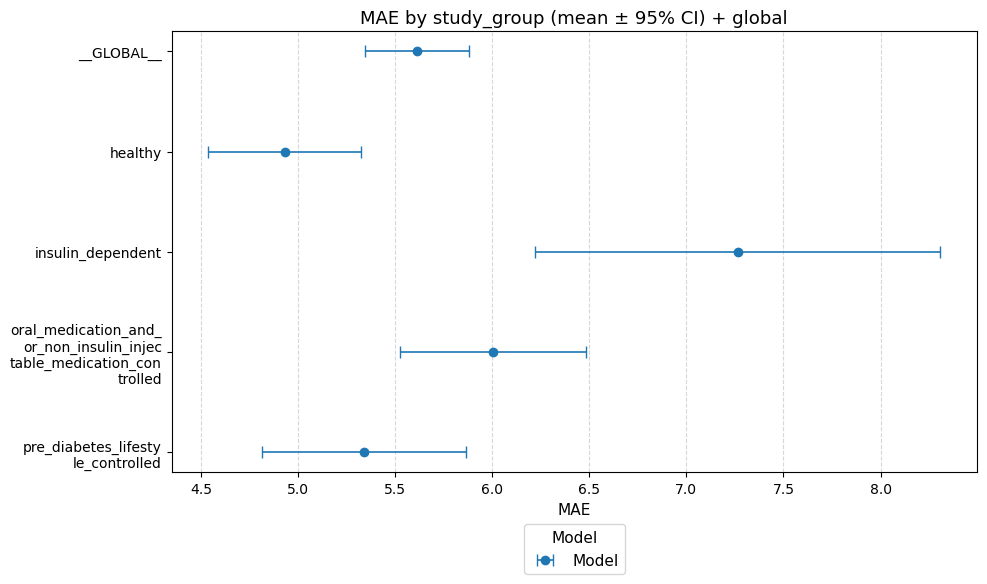

In [37]:
plot_metric_per_category(
    metrics_df,
    metric="MAE",
    by="study_group",
    ci=0.95, ci_method="t")

In [52]:
import numpy as np
import pandas as pd
import textwrap
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

def _pretty_label(s: str):
    if s == "__GLOBAL__":
        return "Global"
    s = s.replace("_", " ")
    # keep lowercase for short prepositions
    return " ".join(w if w in {"and","or","of","to","in","on"} else w.capitalize() for w in s.split())

def plot_metric_per_category_pro(
    model_results,
    metric: str,
    by: str = "study_group",
    ci: float = 0.95,
    wrap_width: int = 24,
    sort_desc: bool = False,       # sort categories by mean (aside from Global)
    marker_size: int = 48,
    line_width: float = 1.4,
    whisker_width: float = 0.9,    # fraction of y-step for CI whiskers
    dpi: int = 200,
    title: str | None = None,
):
    """
    Professional horizontal dot+CI plot: mean ± CI of `metric` by `by`, plus a global row.
    Accepts a single DataFrame or a dict[label->DataFrame].
    Assumes the input already contains Mean/Lo/Hi (95% CI) per category if precomputed,
    otherwise computes them from raw rows.
    """
    # Accept either df or dict
    if isinstance(model_results, pd.DataFrame):
        model_results = {"Model": model_results}

    # Compute mean/CI per category (t-interval; use your previous helper if you prefer bootstrap)
    from scipy.stats import t

    def t_ci(x, level=0.95):
        x = np.asarray(pd.Series(x).dropna().values, dtype=float)
        n = x.size
        if n == 0:
            return np.nan, np.nan, np.nan, 0
        mean = x.mean()
        if n == 1:
            return mean, np.nan, np.nan, n
        sd = x.std(ddof=1)
        sem = sd / np.sqrt(n)
        crit = t.ppf(1 - (1 - level)/2, df=n-1)
        lo, hi = mean - crit*sem, mean + crit*sem
        return mean, lo, hi, n

    rows = []
    for name, df in model_results.items():
        # per-category
        for cat, g in df.groupby(by, dropna=True):
            m, lo, hi, n = t_ci(g[metric])
            rows.append(dict(Model=name, Category=cat, Mean=m, Lo=lo, Hi=hi, N=n))
        # global
        m, lo, hi, n = t_ci(df[metric])
        rows.append(dict(Model=name, Category="__GLOBAL__", Mean=m, Lo=lo, Hi=hi, N=n))

    plot_df = pd.DataFrame(rows)

    # Order: Global first, then categories sorted by mean
    cats = [c for c in plot_df["Category"].unique() if c != "__GLOBAL__"]
    means = plot_df[plot_df["Category"].isin(cats)].groupby("Category")["Mean"].mean()
    cats_sorted = means.sort_values(ascending=not sort_desc).index.tolist()
    order = ["__GLOBAL__"] + cats_sorted

    plot_df["Category"] = pd.Categorical(plot_df["Category"], order)
    plot_df = plot_df.sort_values(["Category","Model"])

    # y positions (top to bottom)
    labels = list(reversed(order))
    y_map = {c: i for i, c in enumerate(labels)}
    plot_df["y"] = plot_df["Category"].map(y_map)

    # Aesthetics
    plt.rcParams.update({
        "font.size": 11,
        "axes.titlesize": 13,
        "axes.labelsize": 11,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    })

    fig_h = max(4.5, 0.42 * len(order) + 1.0)
    fig, ax = plt.subplots(figsize=(6, fig_h), dpi=dpi)

    # Draw: thin CI line + thicker point
    unique_models = plot_df["Model"].unique().tolist()
    y_step = 1.0  # categorical spacing = 1
    hw = whisker_width * y_step / 2  # half whisker height

    for i, model in enumerate(unique_models):
        sub = plot_df[plot_df["Model"] == model]
        # CI segments
        for _, r in sub.iterrows():
            if np.isfinite(r["Lo"]) and np.isfinite(r["Hi"]):
                ax.hlines(r["y"], r["Lo"], r["Hi"], lw=line_width, color="0.25", alpha=0.9)
                # whiskers
                ax.vlines([r["Lo"], r["Hi"]],
                          r["y"]-hw*0.6, r["y"]+hw*0.6, lw=line_width, color="0.25", alpha=0.9)
        # mean points
        ax.scatter(sub["Mean"], sub["y"], s=marker_size, zorder=3, edgecolor="black", linewidth=0.6)

    # Label cleanup & wrapping
    wrapped = ["\n".join(textwrap.wrap(_pretty_label(lbl), width=wrap_width)) for lbl in labels]
    ax.set_yticks([y_map[c] for c in labels])
    ax.set_yticklabels(wrapped)

    ax.set_xlabel(metric)
    if title is None:
        ax.set_title(f"{metric} by {by} (mean ± 95% CI) + Global")

    # Grid/Spines/Ticks
    ax.grid(axis="x", linestyle="--", linewidth=0.6, alpha=0.5)
    for spine in ("top","right"):
        ax.spines[spine].set_visible(False)

    # Nice x-limits with padding
    xmin = np.nanmin(plot_df["Lo"].values)
    xmax = np.nanmax(plot_df["Hi"].values)
    pad = 0.05 * (xmax - xmin if np.isfinite(xmax - xmin) else 1.0)
    if np.isfinite(xmin) and np.isfinite(xmax):
        ax.set_xlim(xmin - pad, xmax + pad)

    # Ticks: sensible number, one decimal
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))

    # Legend: only if multiple models
    if len(unique_models) > 1:
        ax.legend(title="Model", frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.08), ncol=2)
    else:
        # Single model → no legend
        pass

    plt.tight_layout()
    plt.savefig(f"./figures/{metric}_{by}.png", bbox_inches="tight", dpi=1000)
    plt.savefig(f"./figures/{metric}_{by}.svg", bbox_inches="tight")

    plt.show()


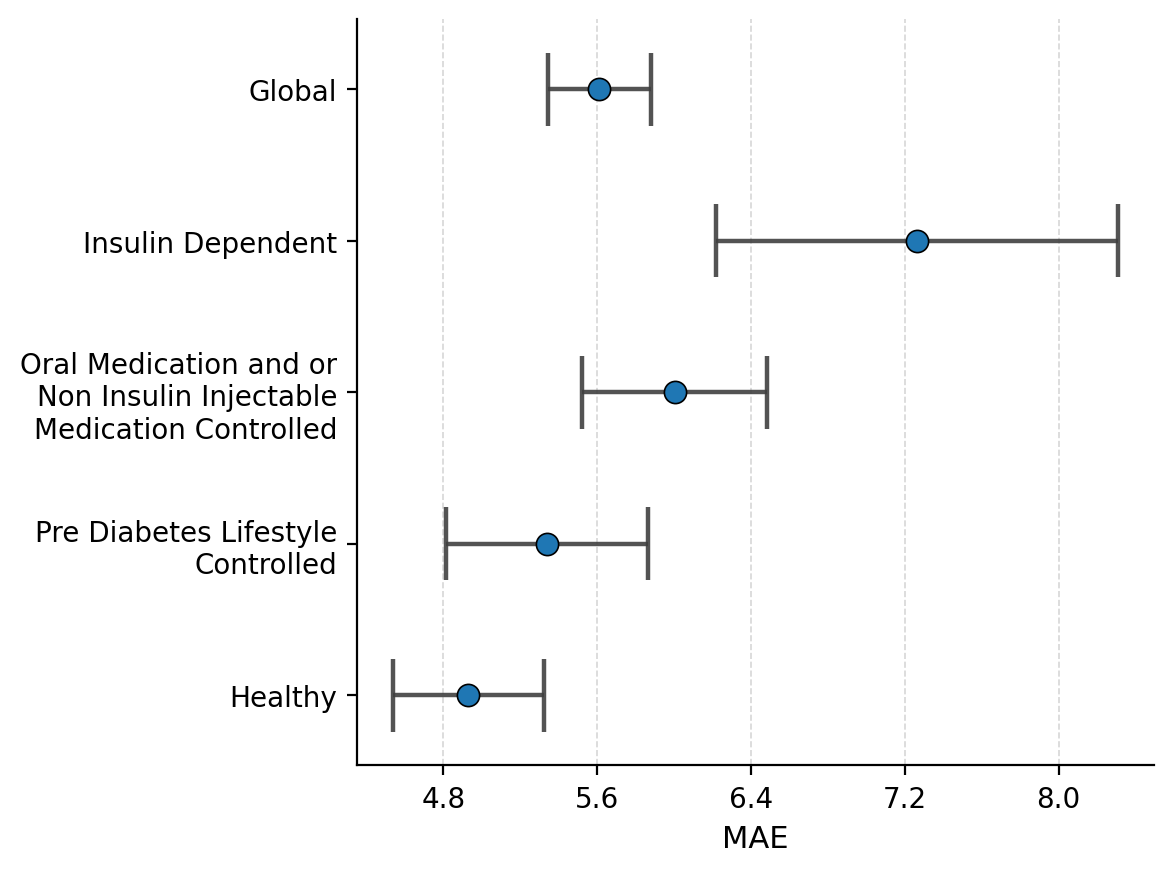

In [53]:
plot_metric_per_category_pro(
    metrics_df,
    metric="MAE",
    by="study_group",
    ci=0.95,
    sort_desc=True,
    marker_size=64,
    line_width=1.6,
    whisker_width=0.8,
    wrap_width=24,
    title="Mean Absolute Error (MAE) by Study Group"
)

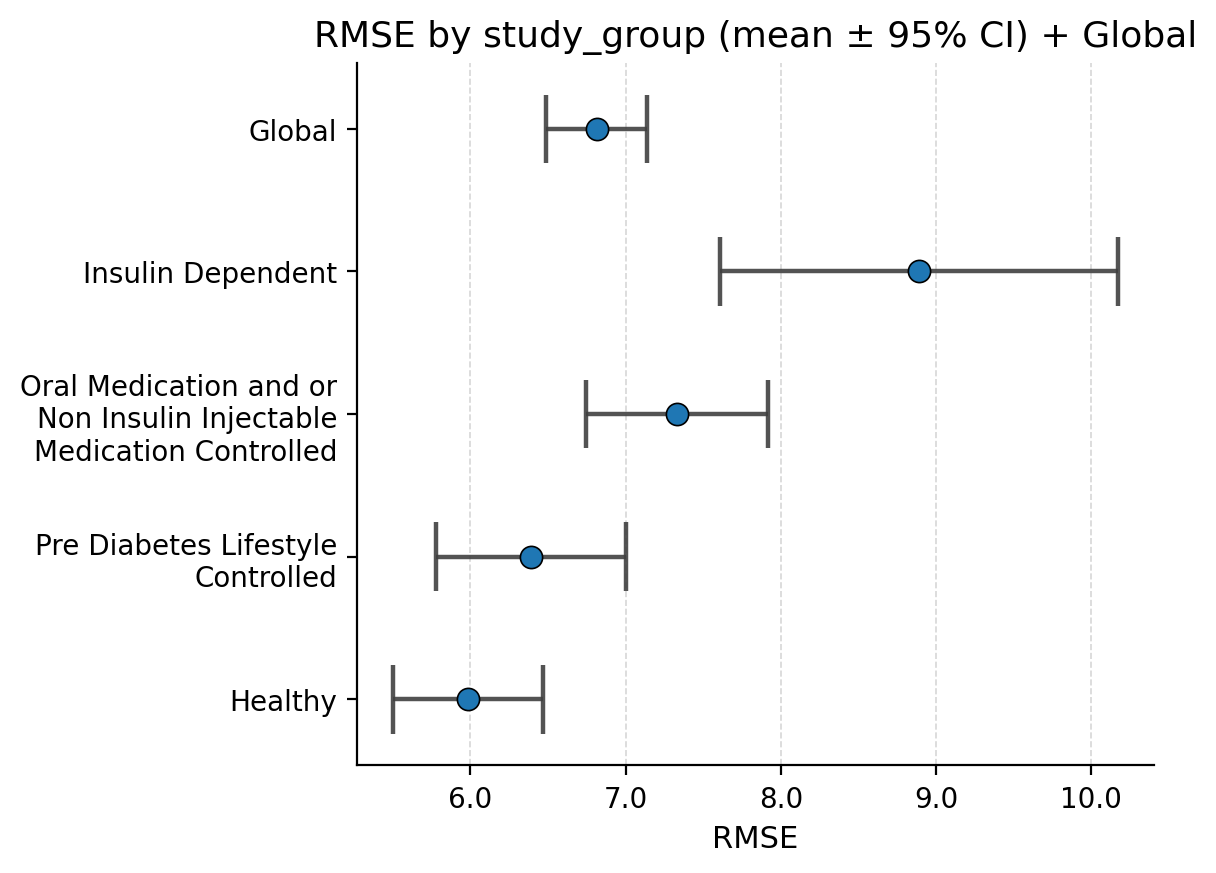

In [55]:
plot_metric_per_category_pro(
    metrics_df,
    metric="RMSE",
    by="study_group",
    ci=0.95,
    sort_desc=True,
    marker_size=64,
    line_width=1.6,
    whisker_width=0.8,
    wrap_width=24
)

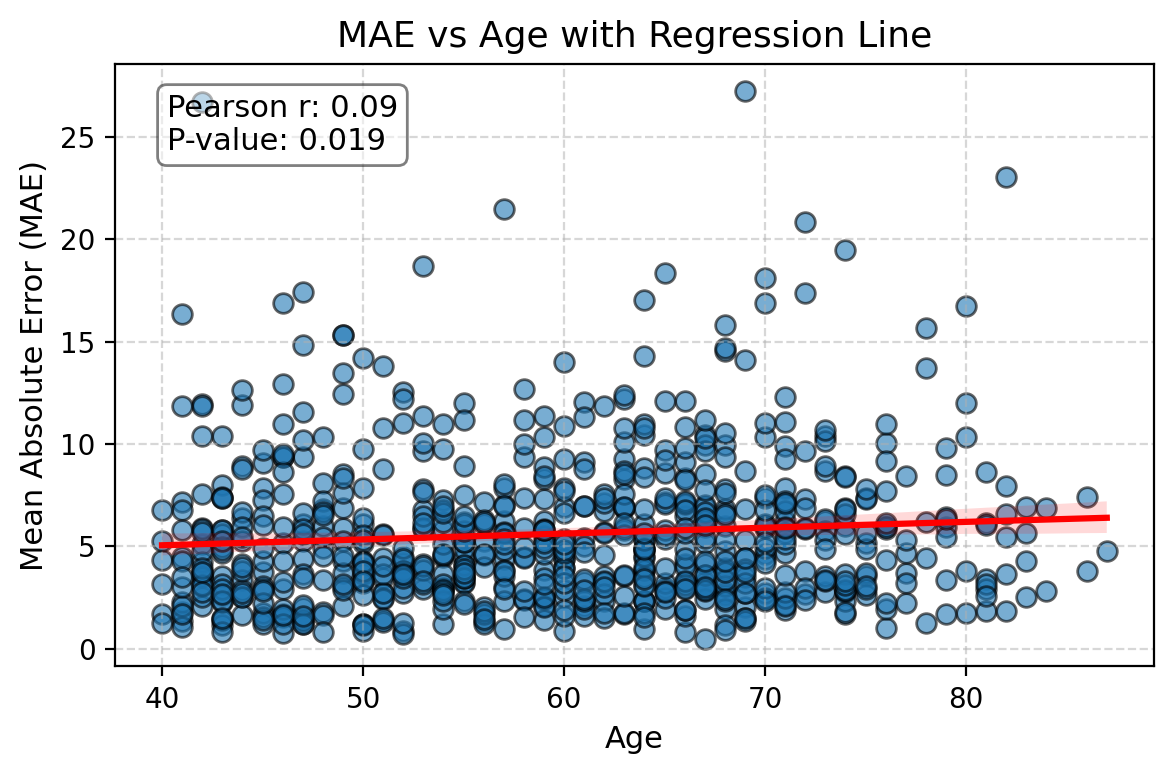

In [57]:
# Plot MAE error as a function of age in metrics_df
# Plot it as a regression line with confidence interval and statistics on R2 or correlation
import seaborn as sns
from scipy.stats import pearsonr
def plot_mae_vs_age_regression_stats(metrics_df):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
    sns.regplot(x='age', y='MAE', data=metrics_df, ax=ax, scatter_kws={'alpha':0.6, 'edgecolor':'k', 's':50}, line_kws={'color':'red'})
    ax.set_xlabel('Age')
    ax.set_ylabel('Mean Absolute Error (MAE)')
    ax.set_title('MAE vs Age with Regression Line')

    # Calculate Pearson correlation
    corr, p_value = pearsonr(metrics_df['age'], metrics_df['MAE'])
    ax.text(0.05, 0.95, f'Pearson r: {corr:.2f}\nP-value: {p_value:.3f}', transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"./figures/MAE_vs_Age_regression.png", bbox_inches="tight", dpi=1000)
    plt.savefig(f"./figures/MAE_vs_Age_regression.svg", bbox_inches="tight")
    plt.show()

plot_mae_vs_age_regression_stats(metrics_df)

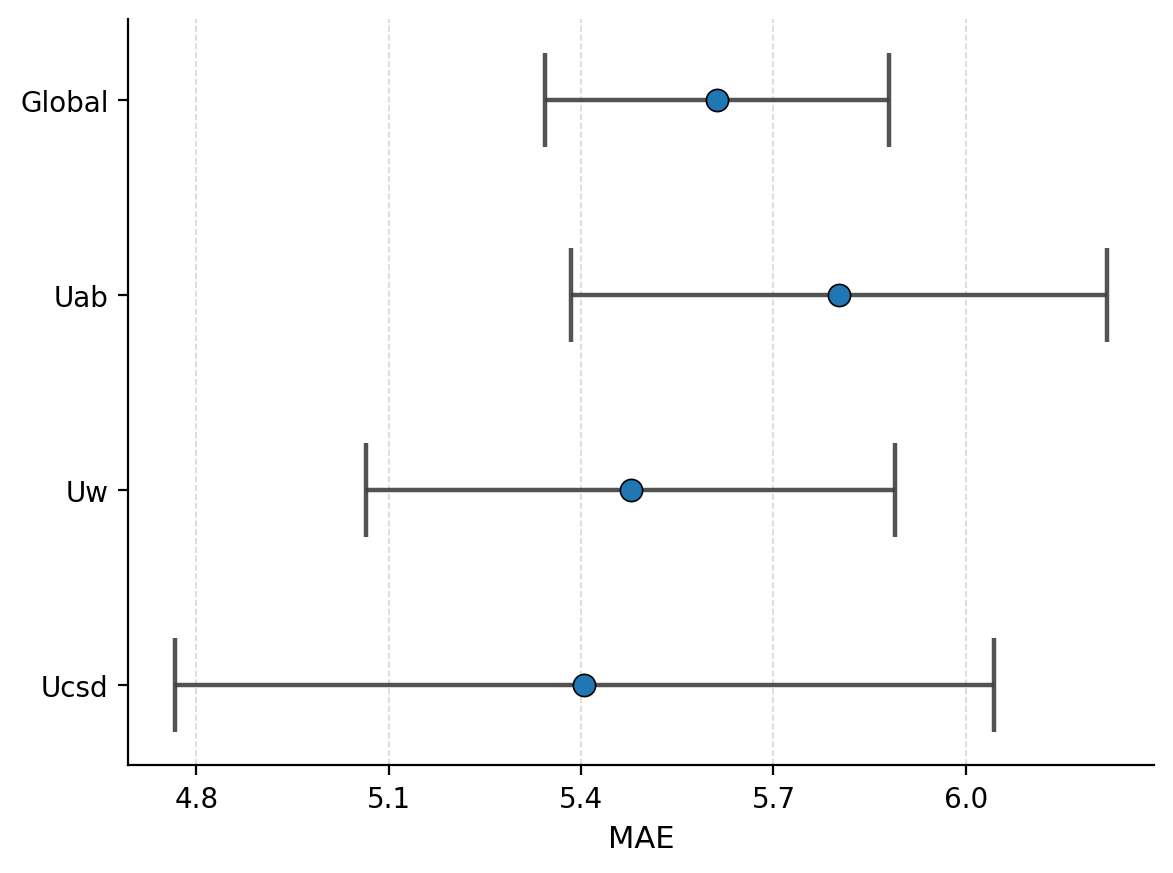

In [56]:
# Plot by clinical site
plot_metric_per_category_pro(
    metrics_df,
    metric="MAE",
    by="clinical_site",
    ci=0.95,
    sort_desc=True,
    marker_size=64,
    line_width=1.6,
    whisker_width=0.8,
    wrap_width=24,
    title="Mean Absolute Error (MAE) by Clinical Site"
)